In [118]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
plt.viridis()
import time
from brian2.units import *

In [29]:
from synaptogenesis.brian_model import BrianModel
from synaptogenesis.pynn_model import PyNNModel

In [31]:
case = 1
duration = 100 * ms
rate = 157.8 * Hz
spike_times = np.linspace(0.1*ms, duration, num=rate * duration)/ms

In [32]:
start = time.time() * second
pynn_model = PyNNModel(seed=7, dimensions=1, case=case, N=1)
pynn_model.record('use_files', False)
pynn_model.set_spike_times(spike_times)
pynn_model.simulate(duration)

v = pynn_model.target.get_v(compatible_output=True)
gsyn = pynn_model.target.get_gsyn(compatible_output=True)
spikes = pynn_model.target.getSpikes(compatible_output=True)
end = time.time() * second
print "PyNN sim done in", end-start

Allocating virtual identifiers
|0                           50%                         100%|
Partitioning graph vertices
|0                           50%                         100%|
Partitioning graph edges
|0                           50%                         100%|
Generating partitioner report
|0                           50%                         100%|
Filtering edges
|0                           50%                         100%|
Placing graph vertices
|0                           50%                         100%|
Generating placement report
|0                           50%                         100%|
Generating placement by core report
|0                           50%                         100%|
Generating SDRAM usage report
|0                           50%                         100%|
Routing
|0                           50%                         100%|
Allocating tags
|0                           50%                         100%|
Reporting Tags
|0                   

PyNN sim done in 3.96600008 s


In [33]:
v = np.asarray(v)
gsyn = np.asarray(gsyn)
spikes = np.asarray(spikes)

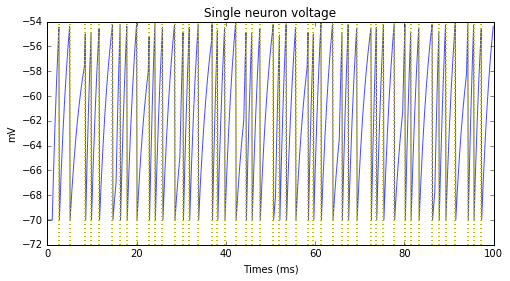

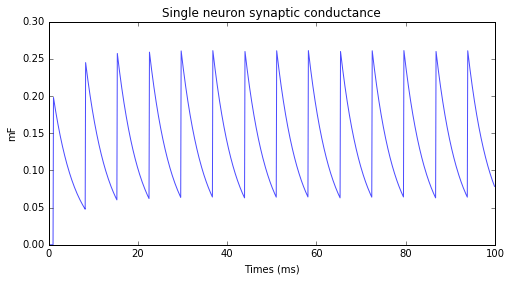

In [34]:
plt.figure(figsize=(8, 4))
plt.title('Single neuron voltage')
plt.xlabel('Times (ms)')
plt.ylabel('mV')
plt.plot(v[:,1],v[:, 2], alpha=.7)
for t in spikes[:, 1]:
    plt.axvline(t, ls=':', c='y', lw=2)

plt.figure(figsize=(8, 4))
plt.title('Single neuron synaptic conductance')
plt.xlabel('Times (ms)')
plt.ylabel('mF')
plt.plot(gsyn[:,1], gsyn[:, 2], alpha=.7)


In [35]:
pynn_rate = spikes[:,1].size / (duration)
print pynn_rate

0.48 kHz


In [36]:
pynn_model.end()

Getting provenance data from partitioned graph
|0                           50%                         100%|
Getting provenance data from partitionable graph
|0                           50%                         100%|
Getting provenance data
|0                           50%                         100%|
Getting Router Provenance
|0                           50%                         100%|


In [37]:
from brian2 import *

In [38]:
# Wiring
n = 1
N = 1
S = (n, n)

s_max = 32
sigma_form_forward = 2.5
sigma_form_lateral = 1
p_form_lateral = 1
p_form_forward = 0.16
p_elim_dep = 0.0245
p_elim_pot = 1.36 * np.e ** -4
f_rew = 10 ** 4 * Hz#Hz

# Membrane
v_rest = -70 * mvolt #mV
e_ext = 0 * mvolt #V
v_thr = -54 * mvolt #mV
g_max = 0.2
tau_m = 20* ms #ms
tau_ex = 5* ms #ms
e = np.e
g = g_max
pre_t = 0 * ms


# Inputs
f_mean = 20 * Hz
f_base = 5 * Hz
f_peak = 152.8  * Hz
sigma_stim = 2
t_stim = 0.02 * second

# STDP
Apre = a_plus = 0.1
b = 1.2
taupre = tau_plus = 20 * ms #ms
taupost = tau_minus = 64 * ms #ms
Apost = a_minus = (a_plus * tau_plus * b) / tau_minus

In [55]:

start = time.time() * second
start_scope()
projections = []
layers = []
neuron_dynamics = '''
dv/dt = (v_rest-v + gex * (e_ext - v))/tau_m : volt
dgex/dt = -gex/tau_ex: 1
s : 1
'''
G = NeuronGroup(N, neuron_dynamics, threshold='v > -54 * mV',
                reset='v = -70 * mV', method='euler', dt=0.1 * ms, name="target_layer")
G.v   = [-70*mV,] * N
G.gex = [0.0, ]   * N
G.s   = [0, ]     * N
layers.append(G)
statemon = StateMonitor(G, ['v', 'gex'], record=True)
spikemon = SpikeMonitor(G)
ratemon  = PopulationRateMonitor(G)



# Pre pop
# inp = NeuronGroup(2, 'rates : Hz', threshold='rand()<rates*dt', dt=0.1 * ms, name="source_layer")
inp = SpikeGeneratorGroup(N, [0]*len(spike_times), spike_times * ms)
layers.append(inp)
# inp.rates = rate

synapse_model = '''
                 w : 1
                 dapre/dt = -apre/taupre : 1 (event-driven)
                 dapost/dt = -apost/taupost : 1 (event-driven)
                 '''
on_pre_model = '''
                 gex_post += w
                 apre += Apre
                 w = clip(w+apost, 0, g_max)
                 '''
on_post_model = '''
                 apost += Apost
                 w = clip(w+apre, 0, g_max)
                 '''

# Feedforward connections (from source to target)
feedforward = Synapses(inp, G, synapse_model, 
                 on_pre = on_pre_model,
                 on_post = on_post_model,
                 dt = .1 * ms, name="feedforward_projections", delay=.1*ms)
feedforward.connect()
feedforward.add_attribute('synapse_connected')
feedforward.synapse_connected = np.zeros(N**2, dtype=np.bool_)
# feedforward.w = [g_max, ] * (N**2)
feedforward.w = g_max
projections.append(feedforward)

# Lateral connections (from target to target)

lateral = Synapses(G, G, synapse_model, 
                 on_pre = on_pre_model,
                 on_post = on_post_model,
                 dt = .1 * ms, name="lateral_projections")
lateral.connect()
lateral.add_attribute('synapse_connected')
lateral.synapse_connected = np.zeros(N**2, dtype=np.bool_)
lateral.w = [0, ] * (N**2)
projections.append(lateral)

inp_spikemon = SpikeMonitor(inp)
inp_ratemon = PopulationRateMonitor(inp)

print "Starting sim"    
run(duration)
print "Sim done"


end = time.time() * second
print "BRIAN sim done in", end - start

Starting sim
Sim done
BRIAN sim done in 7.0079999 s


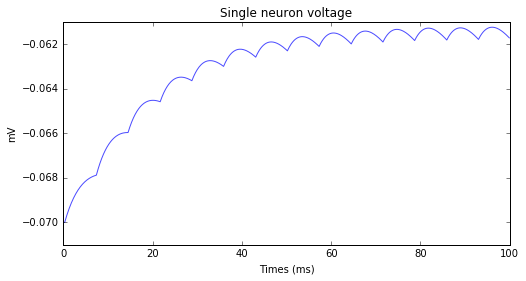

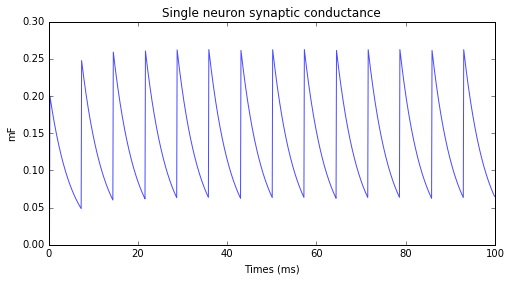

In [56]:
plt.figure(figsize=(8, 4))
plt.title('Single neuron voltage')
plt.xlabel('Times (ms)')
plt.ylabel('mV')
plt.plot(statemon.t/ms, statemon.v[0], alpha=.7)
# for t in spikes[:, 1]:
#     plt.axvline(t, ls=':', c='y', lw=2)
for t in spikemon.spike_trains()[0]:
    axvline(t/ms, ls=':', c='y', lw=2)

plt.figure(figsize=(8, 4))
plt.title('Single neuron synaptic conductance')
plt.xlabel('Times (ms)')
plt.ylabel('mF')
plt.plot(statemon.t/ms, statemon.gex[0], alpha=.7)

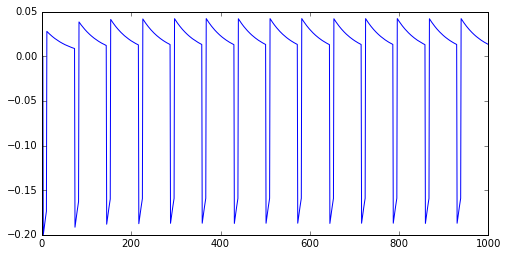

In [57]:
plt.figure(figsize=(8, 4))
plt.plot(gsyn[:, 2] - statemon.gex[0])

In [49]:
np.nonzero(gsyn[:, 2])[0][0]

11

In [43]:
spike_times[0]

0.10000000000000001

In [50]:
gsyn[11, :]

array([ 0.        ,  1.1       ,  0.19800409,  0.        ])

In [51]:
gsyn[12, :]

array([ 0.       ,  1.2      ,  0.1940672,  0.       ])

In [53]:
gsyn[13, :]

array([ 0.        ,  1.3       ,  0.19022187,  0.        ])

In [58]:
np.nonzero(statemon.gex[0])[0][0]

3

In [60]:
# align the g_syns
aligned_brian_gex = np.insert(statemon.gex[0], 0, [0.] * (np.nonzero(gsyn[:, 2])[0][0]-np.nonzero(statemon.gex[0])[0][0]))

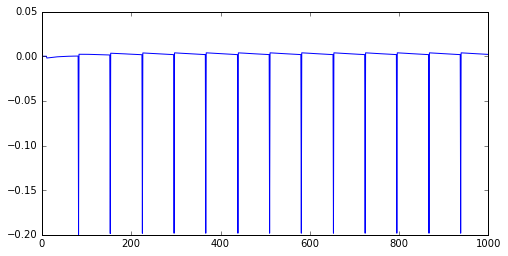

In [62]:
plt.figure(figsize=(8, 4))
plt.plot(gsyn[:, 2] - aligned_brian_gex[0:len(gsyn[:, 2])])

In [63]:
np.diff(spikes[:, 1])

array([ 2.4,  3.5,  1.3,  1.8,  3. ,  1.7,  1.5,  2.2,  2.8,  1.3,  1.7,
        2.7,  1.9,  1.4,  2. ,  3.1,  1.2,  1.6,  2.5,  2.3,  1.3,  1.8,
        3. ,  1.4,  1.5,  2.1,  2.8,  1.2,  1.7,  2.6,  2.1,  1.4,  1.9,
        3.2,  1.2,  1.6,  2.4,  2.4,  1.3,  1.8,  3. ,  1.5,  1.5,  2.2,
        2.8,  1.3,  1.7])

In [65]:
gsyn_diff = gsyn[:, 2] - aligned_brian_gex[0:len(gsyn[:, 2])]

In [72]:
times_of_traughs =  [0 if x > -.05 else index[0] * 0.1 for index, x in np.ndenumerate(gsyn_diff) ]

In [73]:
times_of_traughs

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8.200000000000001,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 15.3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 22.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

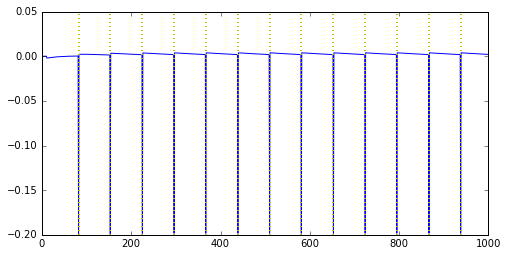

In [74]:
#sanity check 
plt.figure(figsize=(8, 4))
plt.plot(gsyn[:, 2] - aligned_brian_gex[0:len(gsyn[:, 2])])
for t in times_of_traughs:
    plt.axvline(t * 10, ls=':', c='y', lw=2)

In [80]:
time_of_pynn_peaks = [0 if x < .19 else index[0] * 0.1 for index, x in np.ndenumerate(gsyn[:,2]) ]

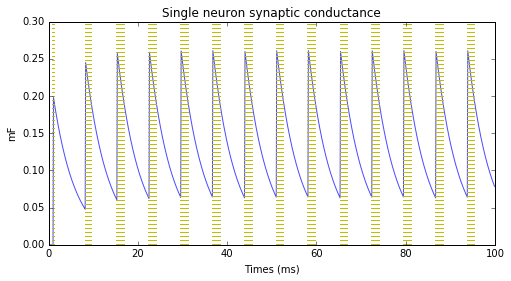

In [81]:
#sanity check 
plt.figure(figsize=(8, 4))
plt.title('Single neuron synaptic conductance')
plt.xlabel('Times (ms)')
plt.ylabel('mF')
plt.plot(gsyn[:,1], gsyn[:, 2], alpha=.7)
for t in time_of_pynn_peaks:
    plt.axvline(t, ls=':', c='y', lw=2)

In [85]:
#isolating peaks
ediff = np.ediff1d(time_of_pynn_peaks)

In [87]:
peak_isolation=[]
for index, value in np.ndenumerate(ediff):
    if value > 0 and ediff[index[0]-1]==0:
        peak_isolation.append(index[0])

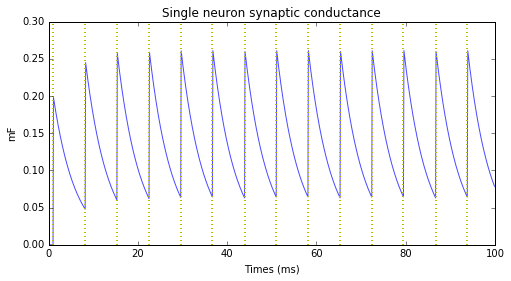

In [91]:
#sanity check 2
plt.figure(figsize=(8, 4))
plt.title('Single neuron synaptic conductance')
plt.xlabel('Times (ms)')
plt.ylabel('mF')
plt.plot(gsyn[:,1], gsyn[:, 2], alpha=.7)
for t in peak_isolation:
    plt.axvline(t/10., ls=':', c='y', lw=2)

In [93]:
np.ediff1d(np.nonzero(times_of_traughs)[0])

array([71, 72, 71, 71, 72, 71, 71, 72, 71, 71, 72, 71])

In [94]:
np.ediff1d(peak_isolation)

array([72, 71, 72, 71, 71, 72, 71, 71, 72, 71, 71, 72, 71])

In [95]:
brain_peaks = []
brian_ediff = np.ediff1d(statemon.gex[0])

In [96]:
brian_ediff

array([ 0.        ,  0.        ,  0.2       , -0.004     , -0.00392   ,
       -0.0038416 , -0.00376477, -0.00368947, -0.00361568, -0.00354337,
       -0.0034725 , -0.00340305, -0.00333499, -0.00326829, -0.00320293,
       -0.00313887, -0.00307609, -0.00301457, -0.00295428, -0.00289519,
       -0.00283729, -0.00278054, -0.00272493, -0.00267043, -0.00261702,
       -0.00256468, -0.00251339, -0.00246312, -0.00241386, -0.00236558,
       -0.00231827, -0.0022719 , -0.00222647, -0.00218194, -0.0021383 ,
       -0.00209553, -0.00205362, -0.00201255, -0.0019723 , -0.00193285,
       -0.0018942 , -0.00185631, -0.00181919, -0.0017828 , -0.00174715,
       -0.0017122 , -0.00167796, -0.0016444 , -0.00161151, -0.00157928,
       -0.0015477 , -0.00151674, -0.00148641, -0.00145668, -0.00142755,
       -0.00139899, -0.00137101, -0.00134359, -0.00131672, -0.00129039,
       -0.00126458, -0.00123929, -0.0012145 , -0.00119021, -0.00116641,
       -0.00114308, -0.00112022, -0.00109781, -0.00107586, -0.00

In [108]:
brian_peak_isolation=[]
for index, value in np.ndenumerate(brian_ediff):
    if value > 0 and brian_ediff[index[0]-1]<=0:
        brian_peak_isolation.append(index[0])

In [109]:
brian_peak_isolation

[2, 73, 144, 216, 287, 358, 430, 501, 572, 644, 715, 786, 858, 929]

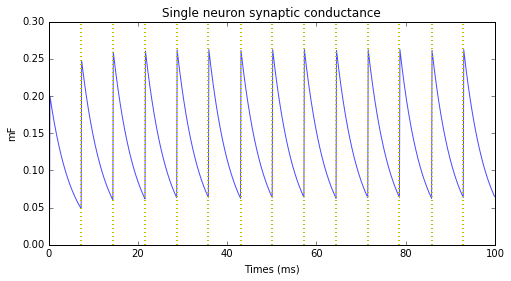

In [110]:
plt.figure(figsize=(8, 4))
plt.title('Single neuron synaptic conductance')
plt.xlabel('Times (ms)')
plt.ylabel('mF')
plt.plot(statemon.t/ms, statemon.gex[0], alpha=.7)
for t in brian_peak_isolation:
    plt.axvline(t/10., ls=':', c='y', lw=2)

In [111]:
brian_peak_ediff = np.ediff1d(brian_peak_isolation)
print brian_peak_ediff
print np.ediff1d(peak_isolation)

[71 71 72 71 71 72 71 71 72 71 71 72 71]
[72 71 72 71 71 72 71 71 72 71 71 72 71]


In [117]:
x = np.asarray([np.ediff1d(peak_isolation),brian_peak_ediff])
np.diff(x, axis=0)

array([[-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [119]:
print scipy.stats.pearsonr(np.ediff1d(peak_isolation),brian_peak_ediff)

(0.8432740427115677, 0.00029286528857172517)
